In [117]:
import requests
import csv
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import random

In [96]:
# Spy data parameters
key='&apikey=ZKMMTO1ATDBLXH2K'
ticker='&symbol=SPY'
endpoint='function=TIME_SERIES_DAILY_ADJUSTED'
size='&outputsize=full'
web='https://www.alphavantage.co/query?'
url =web+endpoint+ticker+size+key

first_date_filter = '2024-01-01'

In [97]:
# Spy Data Pull (dataframe)
r = requests.get(url)
print(r.status_code) # 200 success, 400 not good
data = r.json() # Response is sent in Json format, this allows python to read
meta = data['Meta Data']
time_series_data = data['Time Series (Daily)']

# Collapses the json format to 2d framework like pandas uses
spy_ts_df = pd.DataFrame.from_dict(time_series_data, orient='index').reset_index().rename(columns={'index': 'Date'})

# Cleaner col names
clean_cols_dict = {'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', # Dictionary to convert the names of the columns
            '5. adjusted close': 'Adj Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend', '8. split coefficient': 'Split Coef'}
spy_ts_df = spy_ts_df.rename(columns=clean_cols_dict)

# Making the earliest date the first row, most recent date the last row
spy_ts_df['Date'] = pd.to_datetime(spy_ts_df['Date'])
spy_ts_df = spy_ts_df[spy_ts_df['Date'] >= first_date_filter]
spy_ts_df = spy_ts_df.sort_values(by='Date', ascending=True)
spy_ts_df

200


,Date,Open,High,Low,Close,Adj Close,Volume,Dividend,Split Coef
526,2024-01-02,472.16,473.67,470.49,472.65,461.268009466328,123007793,0.0000,1.0
525,2024-01-03,470.43,471.19,468.17,468.79,457.50096299105,103585866,0.0000,1.0
524,2024-01-04,468.3,470.96,467.05,467.28,456.027325639322,84232169,0.0000,1.0
523,2024-01-05,467.49,470.44,466.43,467.92,456.651913655949,85553758,0.0000,1.0
522,2024-01-08,468.43,474.75,468.3,474.6,463.171051079487,74879074,0.0000,1.0
...,...,...,...,...,...,...,...,...,...
4,2026-02-02,689.58,696.93,689.42,695.41,695.41,77975410,0.0000,1.0
3,2026-02-03,696.21,696.96,684.03,689.53,689.53,105889540,0.0000,1.0
2,2026-02-04,690.35,691.45,681.76,686.19,686.19,105204600,0.0000,1.0
1,2026-02-05,680.94,683.69,675.79,677.62,677.62,113610812,0.0000,1.0


In [98]:
# Fed funds data (dataframe)
ff_url = 'https://www.alphavantage.co/query?function=FEDERAL_FUNDS_RATE&interval=daily'+key
r = requests.get(ff_url)
ff = r.json()
ff_data = ff['data']
print(ff_data)
ff_ts_df = pd.DataFrame.from_dict(ff_data)
ff_ts_df['date'] = pd.to_datetime(ff_ts_df['date'])
ff_ts_df = ff_ts_df[ff_ts_df['date'] >= first_date_filter]
ff_ts_df = ff_ts_df.sort_values(by='date', ascending=True)
ff_ts_df

[{'date': '2026-02-05', 'value': '3.64'}, {'date': '2026-02-04', 'value': '3.64'}, {'date': '2026-02-03', 'value': '3.64'}, {'date': '2026-02-02', 'value': '3.64'}, {'date': '2026-02-01', 'value': '3.64'}, {'date': '2026-01-31', 'value': '3.64'}, {'date': '2026-01-30', 'value': '3.64'}, {'date': '2026-01-29', 'value': '3.64'}, {'date': '2026-01-28', 'value': '3.64'}, {'date': '2026-01-27', 'value': '3.64'}, {'date': '2026-01-26', 'value': '3.64'}, {'date': '2026-01-25', 'value': '3.64'}, {'date': '2026-01-24', 'value': '3.64'}, {'date': '2026-01-23', 'value': '3.64'}, {'date': '2026-01-22', 'value': '3.64'}, {'date': '2026-01-21', 'value': '3.64'}, {'date': '2026-01-20', 'value': '3.64'}, {'date': '2026-01-19', 'value': '3.64'}, {'date': '2026-01-18', 'value': '3.64'}, {'date': '2026-01-17', 'value': '3.64'}, {'date': '2026-01-16', 'value': '3.64'}, {'date': '2026-01-15', 'value': '3.64'}, {'date': '2026-01-14', 'value': '3.64'}, {'date': '2026-01-13', 'value': '3.64'}, {'date': '2026-

,date,value
766,2024-01-01,5.33
765,2024-01-02,5.33
764,2024-01-03,5.33
763,2024-01-04,5.33
762,2024-01-05,5.33
...,...,...
4,2026-02-01,3.64
3,2026-02-02,3.64
2,2026-02-03,3.64
1,2026-02-04,3.64


In [99]:
# Spy returns calculation (dataframe)
returns_df = spy_ts_df[['Date', 'Volume', 'Adj Close']].copy() # Only really need Adj Close and Date for this code
returns_df['Adj Close'] = returns_df['Adj Close'].astype('float') # Price -> Decimal format
returns_df['Daily Log Return'] = np.log(returns_df['Adj Close'] / returns_df['Adj Close'].shift(1)) # log(a) - log(b) = log(a/b)
returns_df

,Date,Volume,Adj Close,Daily Log Return
526,2024-01-02,123007793,461.268009,NaN
525,2024-01-03,103585866,457.500963,-0.008200
524,2024-01-04,84232169,456.027326,-0.003226
523,2024-01-05,85553758,456.651914,0.001369
522,2024-01-08,74879074,463.171051,0.014175
...,...,...,...,...
4,2026-02-02,77975410,695.410000,0.004959
3,2026-02-03,105889540,689.530000,-0.008491
2,2026-02-04,105204600,686.190000,-0.004856
1,2026-02-05,113610812,677.620000,-0.012568


In [100]:
# Spy mean and variance calculation (values)
returns_mean = returns_df['Daily Log Return'].mean()
annual_returns_mean = returns_mean * 252 # Property of log returns, can multiply to get return over that period (252 trading days in a year)

sigma = returns_df['Daily Log Return'].std()
annual_sigma = sigma * (252 ** 0.5) # Because sigma is sqrt of variance, we multiply by sqrt(n)

print(f"SPY Annual Mean {annual_returns_mean} and SPY Annual Sigma {annual_sigma}")

SPY Annual Mean 0.19337860272656232 and SPY Annual Sigma 0.1611326445719874


In [101]:
# Fed Funds Mean
fed_funds_rate_df = ff_ts_df.copy()
fed_funds_rate_df['value'] = fed_funds_rate_df['value'].astype('float')
ff_mean = fed_funds_rate_df['value'].mean() / 100 # a 3.14 value means 3.14% so we convert to 0.0314
annual_ff_mean = np.log(1 + ff_mean) # Annualized return of fed funds

print(f"Annual FF mean {annual_ff_mean}")

Annual FF mean 0.045249539608161075


In [102]:
# Binomial Tree Parameters
T = 0.25 # Total time elapsed (In Years)
n = 63 # Number of steps
h = T/n # Time of 1 step - (If T = 0.25 and n = 63, each step is 0.25/63 years = 1/252 years = 1 trading day)
div = 0.015 # Dividend of the asset

In [ ]:
"""" Explaining u, d, and q for the 3 trees below

FWD:
    (risk_free - dividend) * h is the expected growth of price over h - this is the first half inside math.exp()
    sigma * sqrt(h) is the random shock size of our price over h, this makes sense we use sigma (std dev) - this is the second half inside math.exp()

    u represents the expected growth plus a shock - e^(expected_growth + shock)
    d represents the expected grwoth minus a shock - e^(expected_grwoth - shock)

    e^(one_period_sp_growth - d) / (u - d) gets us q

CCR:
    CCR gets us a similar result with a different path

    Instead of including expected drift in u and d, we have u and d only represent volatility shocks
    We make up for the loss of this expected drift in u and d by increasing q so that u occurs more than d
    Intuitively, if q is increased, we are replacing the drift that occurs each step by making an upward shock more likely

JR:
    Strikes the middle ground between including drift in u and d vs. drift in q

    JR centers u and d around expected drift and volatility so the distribution is symetric in log space
    Idk why/how we would know this, but fun addition


"""

In [ ]:
# Forward Tree Calculations
u_fwd = math.exp((annual_ff_mean - div) * h + annual_sigma * np.sqrt(h)) # Positive return
d_fwd = math.exp((annual_ff_mean - div) * h - annual_sigma * np.sqrt(h)) # Negative Return
q_fwd = (math.exp(annual_returns_mean * h) - d_fwd) / (u_fwd - d_fwd) # Probability of u,  (1-q) for P(d)
# q_fwd_risk_neutral = (math.exp((annual_ff_mean - div) * h) - d_fwd) / (u_fwd - d_fwd)


u_fwd, d_fwd, q_fwd = round(u_fwd, 4), round(d_fwd, 4), round(q_fwd, 4) # Rounding our values

print(f"u_fwd = {u_fwd}, d_fwd = {d_fwd}, q_fwd = {q_fwd}")

u_fwd = 1.0103, d_fwd = 0.99, q_fwd = 0.5294


In [104]:
# Cox Ross Rubenstein (CCR)

u_ccr = math.exp(annual_sigma * np.sqrt(h)) 
d_ccr = math.exp(-annual_sigma * np.sqrt(h))
q_ccr = (math.exp(annual_returns_mean* h) - d_ccr) / (u_ccr - d_ccr)
# q_ccr_risk_neutral = (math.exp((annual_ff_mean - div) * h) - d_ccr) / (u_ccr - d_ccr)

u_ccr, d_ccr, q_ccr = round(u_ccr, 4), round(d_ccr, 4), round(q_ccr, 4)

print(f"u_ccr = {u_ccr}, d_ccr = {d_ccr}, q_ccr = {q_ccr}")

u_ccr = 1.0102, d_ccr = 0.9899, q_ccr = 0.5353


In [106]:
#JR Tree 

u_jr = math.exp((annual_ff_mean - div - 0.5 * annual_sigma ** 2) * h + annual_sigma * np.sqrt(h)) 
d_jr = math.exp((annual_ff_mean - div - 0.5 * annual_sigma ** 2) * h - annual_sigma * np.sqrt(h)) 
q_jr = (math.exp(annual_returns_mean * h) - d_jr) / (u_jr - d_jr)
# q_jr_risk_neutral = (math.exp((annual_ff_mean - div) * h) - d_jr) / (u_jr - d_jr)

u_jr, d_jr, q_jr = round(u_jr, 4), round(d_jr, 4), round(q_jr, 4) 

print(f"u_ccr = {u_jr}, d_ccr = {d_jr}, q_ccr = {q_jr}")

u_ccr = 1.0103, d_ccr = 0.99, q_ccr = 0.5319


In [107]:
# Prices
# This just gets us expected end price without a simulation

a = 561 # In example a has values of 561, 474, 474
b = 10 # In examples b has values of 10, 15, 30
c = 8 # In examples c has values of 8, 9, 10

S_fwd = a * u_fwd ** b *d_fwd ** c
S_ccr = a * u_ccr ** b * d_ccr ** c
S_jr = a * u_jr ** b * d_jr ** c

S_fwd, S_ccr, S_jr = round(S_fwd, 4), round(S_ccr, 4), round(S_jr, 4)

print(f"Prices with a={a}, b={b}, c={c} : S_fwd = {S_fwd}, S_ccr = {S_ccr}, S_jr = {S_jr}")



Prices with a=561, b=10, c=8 : S_fwd = 573.5192, S_ccr = 572.4889, S_jr = 573.5192


In [ ]:
""" Explaining single binomial tree below

    So basically we use the np random seed and np random choice to generate a set of 1's and 0's (u and d) over the # of steps we are using
    We give them q and 1-q as the probabilities of each so that the probability of 1 of the 2 happening is 100% (binomial)
    Once we know whether each step is a u or d, we just apply the u or d we calculated above to our current price, going until we finish our steps

    We store the price at each step in a list so we can plot it like we do below
    This is why we for loop, to retrieve each steps price and add it to the list

    sequence_fwd stores whether we u or d at each step
    
 """

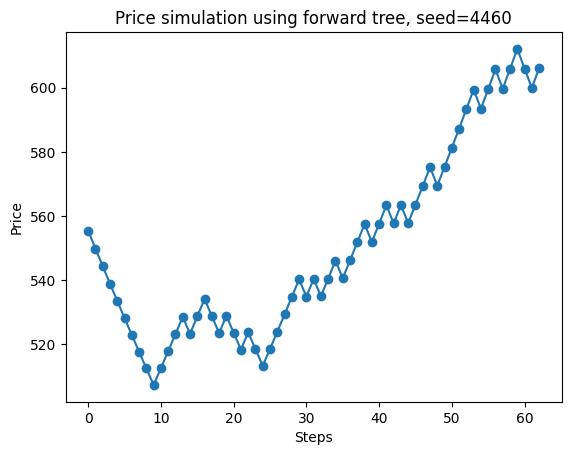

In [113]:
# Simulation of a path using forward tree (Manual way)

np.random.seed(4460) # Keep it the same so we can replicate
sequence_fwd = np.random.choice([0, 1], size=n, p=[1-q_fwd, q_fwd]) # Bernoulli realization with param p
S0 = 561 # Price at T=0

prices_fwd = [] # Where prices will be stored
steps = []

for i in range(len(sequence_fwd)): # We want to generate a price (and subsequent price move from T-1 price) for each step
    if i == 0:
        step_price = 561 * (sequence_fwd[i] * u_fwd + (1 - sequence_fwd[i]) * d_fwd) # Computing the first price
    else:
        step_price = prices_fwd[i - 1] * (sequence_fwd[i] * u_fwd + (1 - sequence_fwd[i])* d_fwd) # Computing subsequent prices based on T-1 price
    prices_fwd.append(step_price) # Adding the price for the given step to our list
    steps.append(i) # Saying which step we are on

plt.plot(steps, prices_fwd, label='Price simulation using forward tree, seed=4460', marker='o')

plt.title('Price simulation using forward tree, seed=4460')
plt.xlabel('Steps')
plt.ylabel('Price')
plt.show()

In [ ]:
""" Explaining Monte Carlo

    Monte Carlo below basically does the tree we create but 10,000 times, and each time has a difference sequence of u's and d's (see where this is going)

    Basically, we generate a new seed for every time, each seed gives us a new sequence (stored within mc_sequence)

    When we have a new sequence for every time, we have a new path, we then show the 10,000 paths calculated in the plot below
    
"""

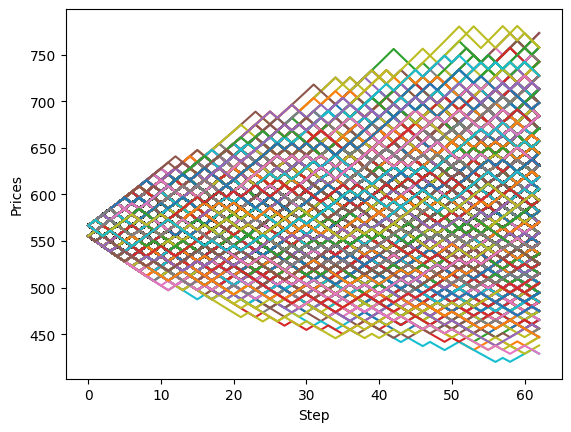

In [114]:
# Monte Carlo Simulation with forward tree variables (can be interchanged with other binary methods)

mc_q, mc_u, mc_d = q_fwd, u_fwd, d_fwd # Can Change fwd to ccr or jr if wanted as well as fwd 
mc_prices = [] # List to store prices but mc stands for monte carlo

for k in range(0, 10000, 1):

    np.random.seed(k) # For each k from 1 - 10,000 we generate a new seed (10,000 simulations)
    mc_sequence = np.random.choice([0, 1], size=n, p=[1-mc_q, mc_q]) # Basically choosing u or d for each step using the probabilities q and -1q
    S0 = 561 # Intial price at T=0
    sim_prices = [] # List of prices for each given simulation
    steps = [] 
    sim_prices.append(561*(mc_sequence[0] * mc_u + (1 - mc_sequence[0]) * mc_d)) # This is S1
    steps.append(0)

    for i in range(1, len(mc_sequence), 1): # Iterate through 1 -> length of mc_sequence_fwd
        step_price = sim_prices[i - 1] * (mc_sequence[i] * mc_u + (1 - mc_sequence[i]) * mc_d)
        sim_prices.append(step_price)
        steps.append(i)
    mc_prices.append(sim_prices)

plt.plot(np.array(mc_prices).T)
plt.xlabel('Step')
plt.ylabel('Prices')
plt.show()


In [115]:
# Computing moments for the distribution of final prices given by the MC simulation
mc_end_prices = []
for i in range(len(mc_prices)):
    sim_end_price = mc_prices[i][62] # Each simulation has 63 steps, so 62 gets us the last value for each sim
    mc_end_prices.append(sim_end_price)

end_prices_df = pd.DataFrame()
end_prices_df['End Price'] = mc_end_prices

end_price_mean = end_prices_df['End Price'].mean()
end_price_sigma = end_prices_df['End Price'].std()

mean_long_return = np.log(end_price_mean) - np.log(S0)

mean_long_return



    

np.float64(0.04757748031943709)

In [ ]:
""" Brownian Motion Portion

The first cell demonstrates how to generate a set of values created from Brownian Motion

The second cell uses the values from above and translates it to Geometric Brownian Motion where we apply it to the price of a fake asset

"""

' Geometric Brownian Motion Portion\n\n    '

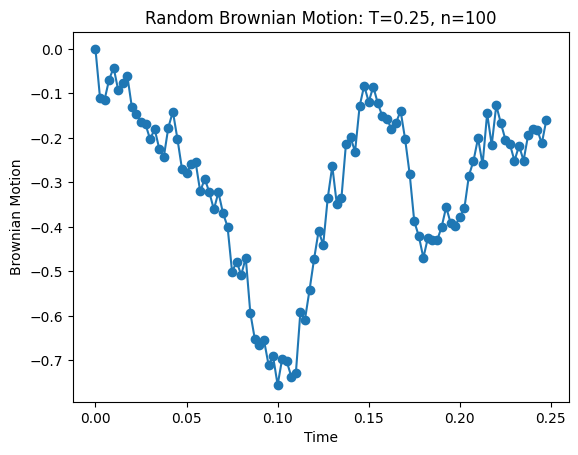

In [ ]:
# Random Brownian Motion over T=0.25, n=100

T = 0.25                # Time (years)
n = 100                 # steps
bTrajectory = [0]       # Stores our movement
time = [0]

for t in range(1, n, 1): # From 1 -> last step
    step = (T / n) * t
    time.append(step)
    rndNumber = random.gauss(0, ((T/n) * t - (T/n) * (t-1)) ** 0.5) # Creating delta = w_t - w_(t-1)
    bTrajectory.append(bTrajectory[t-1] + rndNumber)

plt.plot(time, bTrajectory, marker = 'o')
plt.title('Random Brownian Motion: T=0.25, n=100')
plt.xlabel('Time')
plt.ylabel('Brownian Motion')
plt.show()

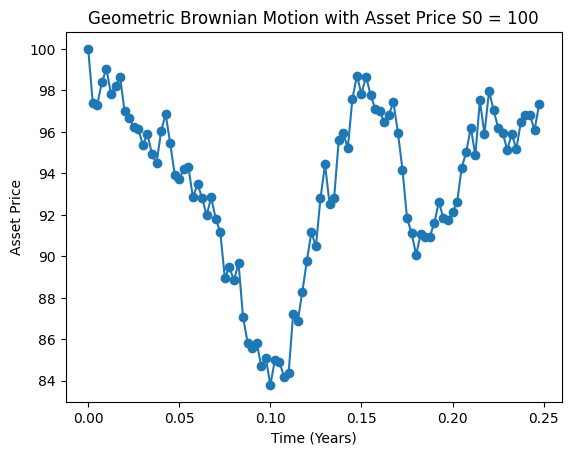

In [121]:
# Geometric Brownian Motion

drift = 0.074
sigma = 0.24
dt = T/n

prices = [100] # List which includes the initial price estimate to start

for i in range(1, len(bTrajectory), 1): # count from 1 to len of bTrajectory, up by 1 each time
    step = prices[0] * np.exp((drift - 0.5 * sigma**2) * (i * dt) + sigma * bTrajectory[i]) # GBM price given W_t
    prices.append(step) # Adding each step to our list of prices

plt.plot(time, prices, marker='o')

plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.title('Geometric Brownian Motion with Asset Price S0 = 100')
plt.show()